# EDA and Data Cleaning



## Outline

1. Read raw data, merge data from separate files and drop duplicates.
2. Inspect DataFrame (shape, dtypes, column names).

3. Process/clean NLP data.
  
    3a. Define functions for cleaning the dataframe and processing.
    
    3b. Check missing values.
    
    3c. Combine `title` and `selftext` columns into one `post` column. This is done to maximize data available and limit posts with only a title and image or short non-descriptive title.
    
    3d. Clean `post` column: remove non-letters and stopwords, make lower case.
    
    
4. `CountVectorize` and check most common words
    4a. Define list of additional meaningless words to remove and clean them. Subreddit names should be included.
5. `TfIdfVectorize` and check words with highest and lowest IDF.
6. Save cleaned `DataFrame` and define data dictionary
    

In [51]:
import praw
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup

In [52]:
# define some functions for printing of markdown tables

def markdown_from_df(df):
    print(f"{df.to_markdown(index=True)}")

def mdtbl_from_df(df):
    
    print(f"| `{df.index.name if df.index.name is not None else ''}` |" + " | ".join([ f"`{c}` "  for c in df.columns])+ "| ")
    print(f"| --- "*(len(df.columns)+1) + " | ")
    for i in df.index:
        print(f"| `{i}` |" + " | ".join([f"{df.loc[i,c]}"  for c in df.columns])+" |")

    return # print(tbl_hdr)

## 1. Read and merge data

In [53]:
import os,sys

flist = sorted([str(f) for f in list(os.listdir('../data')) if 'raw_askastrologers_askastronomy' in f])

df_list=[]
for f in flist:
    print(f)
    df_list.append(pd.read_csv(f'../data/{f}',index_col='name',
                       parse_dates=['created_utc'])[['created_utc','title','selftext','subreddit']])


data_raw_askastrologers_askastronomy_2024-01-27_20-06-07.csv
data_raw_askastrologers_askastronomy_2024-01-27_20-55-01.csv
data_raw_askastrologers_askastronomy_2024-01-29_14-49-04.csv
data_raw_askastrologers_askastronomy_2024-01-29_22-51-36.csv
data_raw_askastrologers_askastronomy_2024-01-30_13-50-47.csv
data_raw_askastrologers_askastronomy_2024-02-01_05-41-35.csv


In [54]:
df_list=df_list[:-1] # pulled last file after writing everything  up

In [55]:
# make combined dataframe
df_merged=pd.concat(df_list,axis=0,join='inner')#drop_duplicates(subset='name').drop(columns=['Unnamed: 0'])

In [56]:
df_merged.head()

,created_utc,title,selftext,subreddit
name,,,,
t3_1acjmvr,2024-01-27 20:06:07,"21F, will be 22 in Feb. Had terrible past rela...",Please explain in layman language. I'm very ne...,askastrologers
t3_1acjm0x,2024-01-27 20:05:05,"Terrifying, but seemingly bang on— Second opin...","F32. Virgo Sun, Scorpio Moon and Sag ascendenc...",askastrologers
t3_1acjgy6,2024-01-27 19:59:11,How will Pluto in Aquarius from 2024 affect me?,I’m sorry if this is a frequent question. But ...,askastrologers
t3_1acjd62,2024-01-27 19:54:33,Should I time my pleasure trip for birthday or...,NaN,askastrologers
t3_1acjb0u,2024-01-27 19:51:56,advice ? compatibility,i’d love a reading or impression,askastrologers


In [57]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9912 entries, t3_1acjmvr to t3_10rbf9h
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   created_utc  9912 non-null   datetime64[ns]
 1   title        9912 non-null   object        
 2   selftext     7728 non-null   object        
 3   subreddit    9912 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 387.2+ KB


## 2. Initial cleaning and inspection

In [58]:
print(f"Number of duplicate rows: {df_merged.duplicated().sum()}")

Number of duplicate rows: 7673


__Drop dupblicate rows__ 

In [59]:
df_merged.drop_duplicates(inplace=True)

In [60]:
df_merged.head(5)

,created_utc,title,selftext,subreddit
name,,,,
t3_1acjmvr,2024-01-27 20:06:07,"21F, will be 22 in Feb. Had terrible past rela...",Please explain in layman language. I'm very ne...,askastrologers
t3_1acjm0x,2024-01-27 20:05:05,"Terrifying, but seemingly bang on— Second opin...","F32. Virgo Sun, Scorpio Moon and Sag ascendenc...",askastrologers
t3_1acjgy6,2024-01-27 19:59:11,How will Pluto in Aquarius from 2024 affect me?,I’m sorry if this is a frequent question. But ...,askastrologers
t3_1acjd62,2024-01-27 19:54:33,Should I time my pleasure trip for birthday or...,NaN,askastrologers
t3_1acjb0u,2024-01-27 19:51:56,advice ? compatibility,i’d love a reading or impression,askastrologers


In [61]:
df_merged.tail()

,created_utc,title,selftext,subreddit
name,,,,
t3_1ae94w9,2024-01-29 23:07:21,need more of an understanding,this is my third one. I’m sorry for posting th...,askastronomy
t3_1ae93zn,2024-01-29 23:06:20,Does anybody know when I will get married and ...,NaN,askastrologers
t3_1ae92vu,2024-01-29 23:05:00,Can someone explain this question to me please,I just need more understandings of this becaus...,askastronomy
t3_1ae91uw,2024-01-29 23:03:42,can someone explain this to me,i need more help understanding this i dont kno...,askastronomy
t3_1ae8wx0,2024-01-29 22:58:01,do i draw in bad luck and financial hardships,is it possible to see that on a birth chart? f...,askastrologers


In [62]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2239 entries, t3_1acjmvr to t3_1ae8wx0
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   created_utc  2239 non-null   datetime64[ns]
 1   title        2239 non-null   object        
 2   selftext     1737 non-null   object        
 3   subreddit    2239 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 87.5+ KB


### Check for missing values

In [63]:
mdtbl_from_df(pd.DataFrame({r"$N$ missing":df_merged.isnull().sum()}))#'Column'})))#,columns=['Column',r'$N$'],=['Column']))

| `` |`$N$ missing` | 
| --- | ---  | 
| `created_utc` |0 |
| `title` |0 |
| `selftext` |502 |
| `subreddit` |0 |


| Column | $N$ missing | 
| --- | ---  | 
| `created_utc` |0 |
| `title` |0 |
| `selftext` |502 |
| `subreddit` |0 |

Lots of missing values in `selftext`. Will merge this column with `title` text below. 

Missing value treatment: only missing values in `selftext`. Will set them to an empty string and merge with `title` column for a combined text column called `post`.

### Check distribution of subreddits

In [64]:
df_merged['subreddit'].value_counts(normalize=True)

askastrologers    0.549352
askastronomy      0.450648
Name: subreddit, dtype: float64

In [65]:
print(df_merged['subreddit'].value_counts())
print(df_merged['subreddit'].value_counts(normalize=True))

askastrologers    1230
askastronomy      1009
Name: subreddit, dtype: int64
askastrologers    0.549352
askastronomy      0.450648
Name: subreddit, dtype: float64



|    `subreddit`            |   $N$ submissions |   Proportion | 
|:---------------|------------:|------------:|
| `askastrologers` |        1230 |    0.549352 |
| `askastronomy`   |        1009 |    0.450648 |

The data is pretty evenly distributed in terms of submissions with `askastrologers` as the majority class representing 55% of all submissions.

Check datatypes

In [23]:
df_merged.dtypes

created_utc    datetime64[ns]
title                  object
selftext               object
subreddit              object
dtype: object

## 3. NLP and Cleaning data

### 3a. Define functions for NLP

In [66]:
import re
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer



# clean string containing raw text data to return only lowercase, meaningfull words
def post_to_words(raw_text):

    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)


    # 1. Remove HTML.
    # text = BeautifulSoup(raw_text).get_text()
    # print(text)
    # 2. Remove apostrophes and suffixes/non-letters
    # text = re.sub(r'[\':\b]\w+','',raw_text)
    letters_only = re.sub(r"[^a-zA-Z]", " ", raw_text)
    
    
    # print(letters_only)
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()



    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words and lemmatize the words    
    lemmatizer = WordNetLemmatizer()

    meaningful_words = [lemmatizer.lemmatize(w) for w in words if w not in stops]# and (len(w)>1)]

    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return (" ".join(meaningful_words))

# function to clean/process input dataframe: 1) create merged text data and 2) perform NLP and clean text data
def clean_subreddit_df(df):
    
    # make copy of original dataframe
    df_cln=df.copy()#merge_text_columns(df)

    # 1) drop duplicates (just in case)
    df_cln.drop_duplicates(inplace=True)

    # 2) fill NaNs in selftext with empty string, add it to title column to make "post" column
    df_cln['post']=df_cln['title']+' '+df_cln['selftext'].fillna('')

    # 3) clean text column using post_to_words NLP function above
    df_cln['post']=[post_to_words(str(p)) for p in df_cln['post']]

    # return cleaned dataframe with the name as index, time, post (feature colummn), and subreddit (target column)
    return df_cln[['created_utc','post','subreddit']]

### 3b-3d. NLP and cleaning of text data 


`clean_subreddit_df` defined above takes the raw `DataFrame` with columns: `created_utc`, `title`, `selftext`,`subreddit` 

returns `DataFrame` with column `post`: cleaned, combined `title` and `selftext` columns 

In [67]:
df_clean = clean_subreddit_df(df_merged)

In [68]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2239 entries, t3_1acjmvr to t3_1ae8wx0
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   created_utc  2239 non-null   datetime64[ns]
 1   post         2239 non-null   object        
 2   subreddit    2239 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 70.0+ KB


Let's look at some post text examples

In [69]:
mdtbl_from_df(df_clean[['created_utc','post','subreddit']][df_clean['subreddit']=='askastronomy'].head())
print('\n\n')
mdtbl_from_df(df_clean[['created_utc','post','subreddit']][df_clean['subreddit']=='askastrologers'].head())

| `name` |`created_utc`  | `post`  | `subreddit` | 
| --- | --- | --- | ---  | 
| `t3_1acb51z` |2024-01-27 13:44:52 | master astronomy ece join college soon india right available option electrical engineering want make career astronomy astrophysics go master usa possible master astronomy electrical electronic engineering | askastronomy |
| `t3_1ac65td` |2024-01-27 08:21:38 | plane stellar planetary system oriented parallel milky way generally tilted like | askastronomy |
| `t3_1absdye` |2024-01-26 20:42:56 | brightness magnitude solar eclipse asking search magnitude eclipse return page much coverage moon sun approximate brightness solar eclipse purchased new lens prior experience photographing eclipse turned exposed like experiment moon phase would somewhat similar would see eclipse thanks guidance advance | askastronomy |
| `t3_1abncxc` |2024-01-26 17:09:56 | derivative position defines freefall always thought never really made sense define acceleration due gravity set distance source

| `name` |`created_utc`  | `post`  | `subreddit` | 
| --- | --- | --- | ---  | 
| `t3_1acb51z` |2024-01-27 13:44:52 | master astronomy ece join college soon india right available option electrical engineering want make career astronomy astrophysics go master usa possible master astronomy electrical electronic engineering | askastronomy |
| `t3_1ac65td` |2024-01-27 08:21:38 | plane stellar planetary system oriented parallel milky way generally tilted like | askastronomy |
| `t3_1absdye` |2024-01-26 20:42:56 | brightness magnitude solar eclipse asking search magnitude eclipse return page much coverage moon sun approximate brightness solar eclipse purchased new lens prior experience photographing eclipse turned exposed like experiment moon phase would somewhat similar would see eclipse thanks guidance advance | askastronomy |
| `t3_1abncxc` |2024-01-26 17:09:56 | derivative position defines freefall always thought never really made sense define acceleration due gravity set distance source gravity since acceleration change based distance freefall time derivative position exactly would someone solve say position travelled integral km earth straight freefall could iterated integration really used define something like like would normal function acceleration jerk familiar mathematics beyond multivariable calculus know aspect differential modeling | askastronomy |
| `t3_1abcko8` |2024-01-26 07:11:24 | uranus truly impressive colour difference image extremely saturated plant different blue white coloured cloud | askastronomy |







| `name` |`created_utc`  | `post`  | `subreddit` | 
| --- | --- | --- | ---  | 
| `t3_1acjmvr` |2024-01-27 20:06:07 | f feb terrible past relationship could reason new possibility getting long term relationship anytime soon thank please explain layman language new | askastrologers |
| `t3_1acjm0x` |2024-01-27 20:05:05 | terrifying seemingly bang second opinion f virgo sun scorpio moon sag ascendence gone tumultuous ending relationship last year facing heat work six month spoke astrologer first time ever mostly needed reading around work growth health relationship reading seemed alignment high low life looked like far pointed something nothing come easy take lot failure reach goal accurate anyone gauged life eventually took three attempt fully open tell never seen tumultuous chart everything seems getting affected reason despite best effort chart apparently show lot struggle result late predicted success relationship miscarriage attempt child want kid definitely slow growth career tough work week passed honestly listening anyone want read offer word hopefully strangest chart seen | askastrologers |
| `t3_1acjgy6` |2024-01-27 19:59:11 | pluto aquarius affect sorry frequent question aquarius placement kinda concerned interpretation extra information welcome well | askastrologers |
| `t3_1acjd62` |2024-01-27 19:54:33 | time pleasure trip birthday yearly sun chart ruler transit | askastrologers |
| `t3_1acjb0u` |2024-01-27 19:51:56 | advice compatibility love reading impression | askastrologers |

## 4. EDA and Further Data Cleaning



 #### Vectorization with `CountVectorizer` and `TfidfVectorizer`

Define feature matrix `X` and target vector `y`

In [70]:
X = df_clean['post']
y = df_clean['subreddit']

In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvec = CountVectorizer(max_features=5000,stop_words='english',\
                       ngram_range=(1,1),min_df=2,token_pattern=r"\b[a-zA-Z]+\b")

In [72]:
#fit transform
X_cvec = cvec.fit_transform(X)

# make vectorized dataframe
X_cvec = pd.DataFrame(X_cvec.toarray(),columns=cvec.get_feature_names_out(),index=X.index)


#### Visualize most common words in both classes

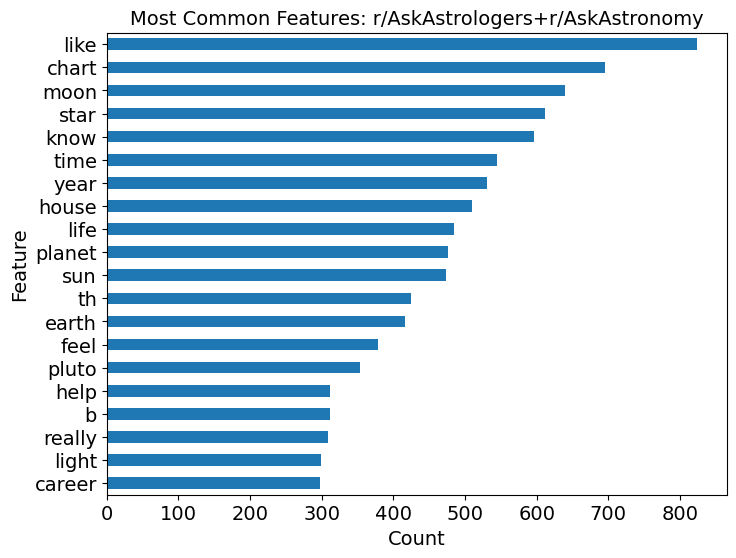

In [73]:
f = plt.figure(figsize=(8,6))
# X[y=='science'].sum().sort_values().tail(10).plot(kind='bar',color='red',figsize=(10,6))
X_cvec.sum().sort_values().tail(20).plot(kind='barh',fig=f);

plt.tick_params(axis='both',labelsize=14)
plt.xlabel("Count",fontsize=14)
plt.ylabel("Feature",fontsize=14)
plt.title("Most Common Features: r/AskAstrologers+r/AskAstronomy",fontsize=14)
plt.savefig("../images/common_words_counts_both.png",dpi=150,bbox_inches='tight')
plt.show()

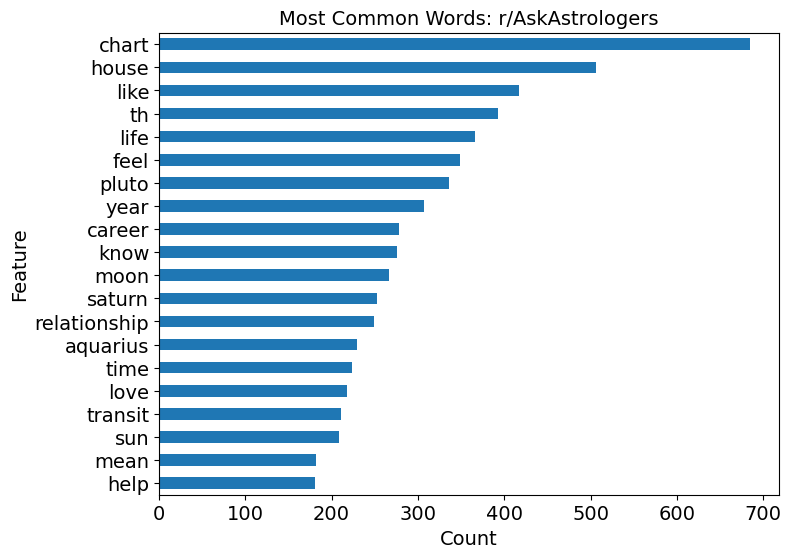

In [74]:
f = plt.figure(figsize=(8,6))

# X[y=='science'].sum().sort_values().tail(10).plot(kind='bar',color='red',figsize=(10,6))
X_cvec[y=='askastrologers'].sum().sort_values().tail(20).plot(kind='barh',fig=f);

plt.tick_params(axis='both',labelsize=14)
plt.xlabel("Count",fontsize=14)
plt.ylabel("Feature",fontsize=14)
plt.title("Most Common Words: r/AskAstrologers",fontsize=14)
plt.savefig("../images/common_words_counts_astrol.png",dpi=150,bbox_inches='tight')

plt.show()

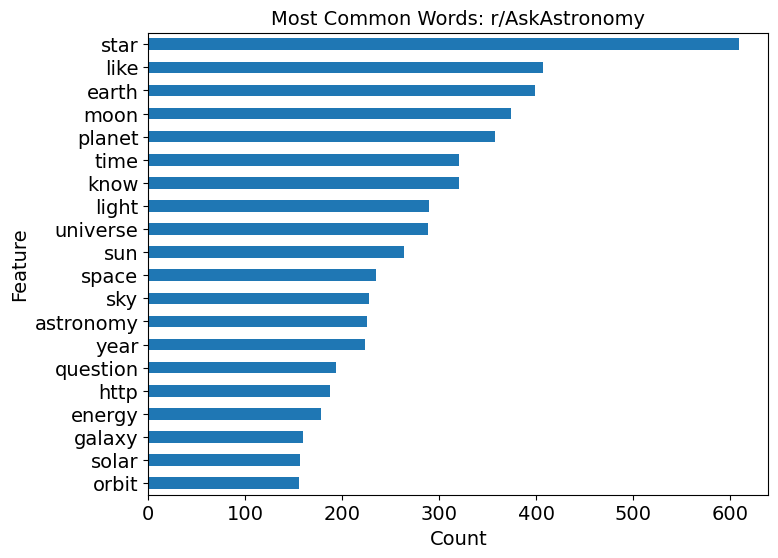

In [75]:
f = plt.figure(figsize=(8,6))

# X[y=='science'].sum().sort_values().tail(10).plot(kind='bar',color='red',figsize=(10,6))
X_cvec[y=='askastronomy'].sum().sort_values().tail(20).plot(kind='barh',fig=f);

plt.tick_params(axis='both',labelsize=14)
plt.xlabel("Count",fontsize=14)
plt.ylabel("Feature",fontsize=14)
plt.title("Most Common Words: r/AskAstronomy",fontsize=14)
plt.savefig("../images/common_words_counts_astron.png",dpi=150,bbox_inches='tight')

plt.show()

In [76]:
# vocab_cv= cvec.get_feature_names_out()
# counts = pd.DataFrame(zip(vocab_cv, X_cvec[y=='askastrologers'].sum(), X_cvec[y=='askastronomy'].sum()),
#                        columns=['vocabulary', 'count_astrol','count_astron'])#print([f"{i}:{X_cvec.sum().sort_values(ascending=False).loc[i]}" for i in X_cvec.sum().sort_values(ascending=False).index[:100]])

In [77]:
# overlap = counts['count_astrol']/counts[['count_astrol','count_astron']].sum(axis=1)

# overlap = (counts['count_astron']-counts['count_astrol']).abs()/counts[['count_astrol','count_astron']].sum(axis=1)

In [78]:
# counts['vocabulary'].iloc[np.where(overlap!=0)].iloc[np.argsort(1./overlap[overlap!=0])]

#### `CountVectorizer` results:

- We can define a list of custom stop words which warrant cleaning: "like", "th", "http", "www", "com", "png", "jpg", "gif", "pdf", "b" (and any one-letter word), "astronomy", "astronomer", "astrology", "astrologer"
- Although there are some overlapping words ("like", "moon", "sun") some stark differences are observed: askastrology has words like "feel", "life", "relationship", "love" related to emotional issues and personal matters whereas askastronomy has words like "star", "galaxy", "light", "energy", and "orbit" related to astrophysical objects and understanding. 


In [79]:
char_count = [len(s.split()) for s in df_clean['post']]
# char_count_selftext = [len(s.split()) if type(s)==str else 0 for s in df_clean['selftext']]

word_count_df=pd.DataFrame({'subreddit':df_clean['subreddit'],
                               'count':char_count},index=df_clean.index)
                               # 'selftext_count':char_count_selftext},index=df.index)


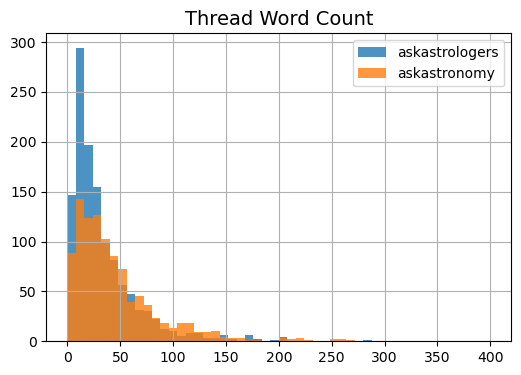

In [89]:
f=plt.figure(figsize=(6,4))
ax=plt.subplot()
ax.set_title("Thread Word Count",fontsize=14)
word_count_df[word_count_df['subreddit']=='askastrologers']['count'].hist(bins=50,alpha=0.8,ax=ax,range=[0,400])
word_count_df[word_count_df['subreddit']=='askastronomy']['count'].hist(bins=50,ax=ax,alpha=0.8,range=[0,400])
ax.legend(['askastrologers','askastronomy'])
plt.show()

Some interesting conclusions can be drawn from this:


- `nebula`, `moon`, `star` are top 3 words in astronomy while `astrology`, `chart`, and `house` for astrology. The words `astronomy` and `astrology` should be excluded as stop words.

- `s` and `t` as a single character show up in both top word lists and should be removed.


__Define list of additional stop words:__

## 5. `TfIDF` Vectorizer

In [90]:
tf = TfidfVectorizer(max_features=5000,stop_words='english',
                       ngram_range=(1,1),token_pattern=r"\b[a-zA-Z]+\b")

X_tf = tf.fit_transform(X)
X_tf = pd.DataFrame(X_tf.todense(), columns=tf.get_feature_names_out(), index=X.index)

In [91]:
vocab_tf= tf.get_feature_names_out()
idf = pd.DataFrame(zip(vocab_tf, tf.idf_), columns=['vocabulary', 'IDF'])

In [92]:
idf.sort_values(by='IDF').head()

,vocabulary,IDF
2479,like,2.373872
664,chart,2.544620
2380,know,2.572194
4414,time,2.774060
4949,year,2.833698


/var/folders/t0/z45sbs_x4qggjl5km6v2t42m0000gn/T/ipykernel_36177/4267334654.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../images/idf_vocab_both.png',bbox_inches='tight',figsize=(6,6))


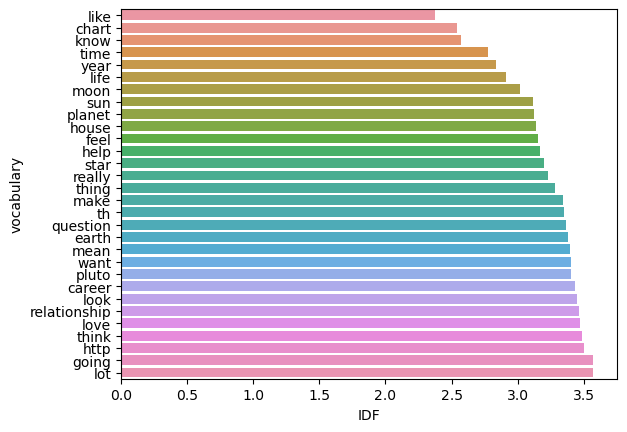

In [101]:
import seaborn as sns
plt.figure()
sns.barplot(y=idf.sort_values(by='IDF',ascending=True).head(30)['vocabulary'],x=idf.sort_values(by='IDF').head(30)['IDF'],orientation='horizontal')#y=idf['IDF'])
plt.savefig('../images/idf_vocab_both.png',bbox_inches='tight',figsize=(6,6))
plt.show()

/var/folders/t0/z45sbs_x4qggjl5km6v2t42m0000gn/T/ipykernel_36177/1594353201.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../images/idf_vocab_least.png',bbox_inches='tight',figsize=(6,6))


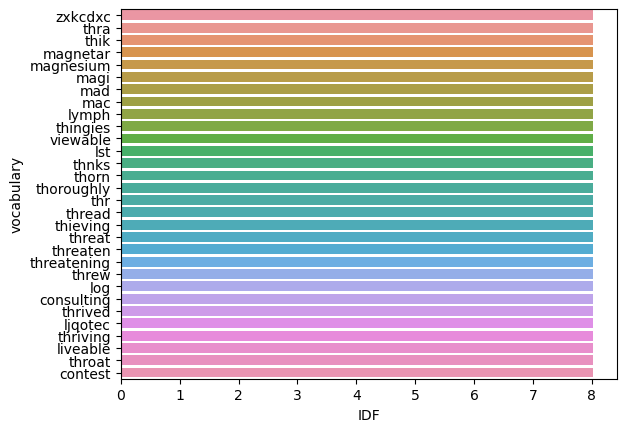

In [100]:
import seaborn as sns
plt.figure()
sns.barplot(y=idf.sort_values(by='IDF',ascending=False).head(30)['vocabulary'],
            x=idf.sort_values(by='IDF',ascending=False).head(30)['IDF'],orientation='horizontal')#y=idf['IDF'])
plt.savefig('../images/idf_vocab_least.png',bbox_inches='tight',figsize=(6,6))
plt.show()

In [85]:
idf.sort_values(by='IDF').tail()

,vocabulary,IDF
479,bode,8.021084
4255,tear,8.021084
4256,tearing,8.021084
494,bot,8.021084
4999,zxkcdxc,8.021084


In [86]:
# define cleaning function
def clean_post(post, exclude_list=["like", "th", "http", "www", "com",
                  "png", "jpg", "gif", "pdf", "astronomy", "astronomer", "astrology", "astrologer"]):
    return " ".join([w for w in post.split() if len(w)>1 and w not in exclude_list])


In [45]:
# clean post column by mapping with clean function above
df_clean['post'] = df_clean['post'].map(clean_post)#, exclude_words)

In [46]:
df_clean.head()

,created_utc,post,subreddit
name,,,
t3_1acjmvr,2024-01-27 20:06:07,feb terrible past relationship could reason ne...,askastrologers
t3_1acjm0x,2024-01-27 20:05:05,terrifying seemingly bang second opinion virgo...,askastrologers
t3_1acjgy6,2024-01-27 19:59:11,pluto aquarius affect sorry frequent question ...,askastrologers
t3_1acjd62,2024-01-27 19:54:33,time pleasure trip birthday yearly sun chart r...,askastrologers
t3_1acjb0u,2024-01-27 19:51:56,advice compatibility love reading impression,askastrologers


In [47]:
mdtbl_from_df(df_clean[['created_utc','post','subreddit']][df_clean['subreddit']=='askastronomy'].head())
print('\n\n')
mdtbl_from_df(df_clean[['created_utc','post','subreddit']][df_clean['subreddit']=='askastrologers'].head())

| `name` |`created_utc`  | `post`  | `subreddit` | 
| --- | --- | --- | ---  | 
| `t3_1acb51z` |2024-01-27 13:44:52 | master ece join college soon india right available option electrical engineering want make career astrophysics go master usa possible master electrical electronic engineering | askastronomy |
| `t3_1ac65td` |2024-01-27 08:21:38 | plane stellar planetary system oriented parallel milky way generally tilted | askastronomy |
| `t3_1absdye` |2024-01-26 20:42:56 | brightness magnitude solar eclipse asking search magnitude eclipse return page much coverage moon sun approximate brightness solar eclipse purchased new lens prior experience photographing eclipse turned exposed experiment moon phase would somewhat similar would see eclipse thanks guidance advance | askastronomy |
| `t3_1abncxc` |2024-01-26 17:09:56 | derivative position defines freefall always thought never really made sense define acceleration due gravity set distance source gravity since acceleration change based

In [95]:
print(pd.DataFrame(df_clean.dtypes).to_markdown())

|             | 0              |
|:------------|:---------------|
| created_utc | datetime64[ns] |
| post        | object         |
| subreddit   | object         |


## 6. Data Dictionary and save cleaned `DataFrame`

File: [`data_cleaned_askastrologers_askastronomy.csv`](../data/data_cleaned_askastrologers_askastronomy.csv)


  Column     |  Dtype  | Description       
|:------------|:---------------|----|
| `created_utc` | `datetime64[ns]` | UTC in YYYY-MM-DD HH:MM:SS format.
| `post`        | `object`         | Column representing combined `title` and `selftext` from subreddit posts. 
| `subreddit`   | `object`         | Subreddit label (`askastrologers` or `askastronomy`).

In [96]:
df_clean.to_csv("../data/data_cleaned_askastrologers_askastronomy.csv",index=True)